In [21]:
import json
from utils.gho_filter import filter_gho_users

with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

gho_users = set(filter_gho_users(data))
borrowers = set([e['id'] for e in data if e['borrowHistory']])

In [8]:
def get_gho_usage(history: dict, action: str) -> bool:
    for action in history[action]:
        if 'reserve' in action:
            if action['reserve']['symbol'] == 'GHO':
                return True
    return False

transactions = []
histories = ['borrowHistory']
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            transactions += [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
user_transactions = {}
first_transactions = {}
full_transactions = {}
mint_transactions = set()
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_transactions[entry['id']] = len(user_gho_transactions)
            mint_transactions |= set(user_gho_transactions)
            first_transaction = min([c['timestamp'] for c in entry[history] if c['reserve']['symbol'] == 'GHO'])
            first_transactions[entry['id']] = first_transaction
            full_transactions[entry['id']] = [c for c in entry[history] if c['reserve']['symbol'] == 'GHO']

## Number of GHO mints per user

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [10]:
df_txs = pd.DataFrame.from_dict(user_transactions, orient='index').reset_index()
df_txs.columns = ['user', 'count']

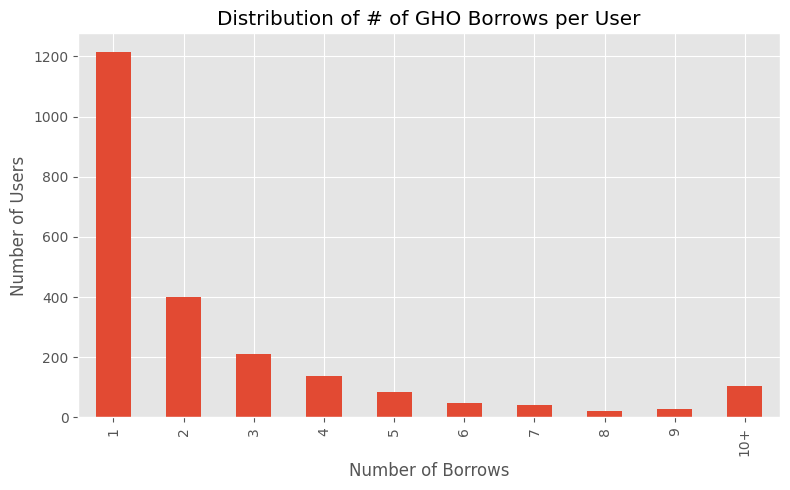

In [11]:
df_txs['count'] = np.where(df_txs['count'] > 10, 10, df_txs['count'])
counts = df_txs['count'].value_counts().sort_index()
counts = counts.rename(index={10: '10+'})

fig, ax = plt.subplots(figsize=(8, 5))
counts.plot(kind='bar', ax=ax)

ax.set_xlabel('Number of Borrows')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of # of GHO Borrows per User')

plt.tight_layout()
plt.show()

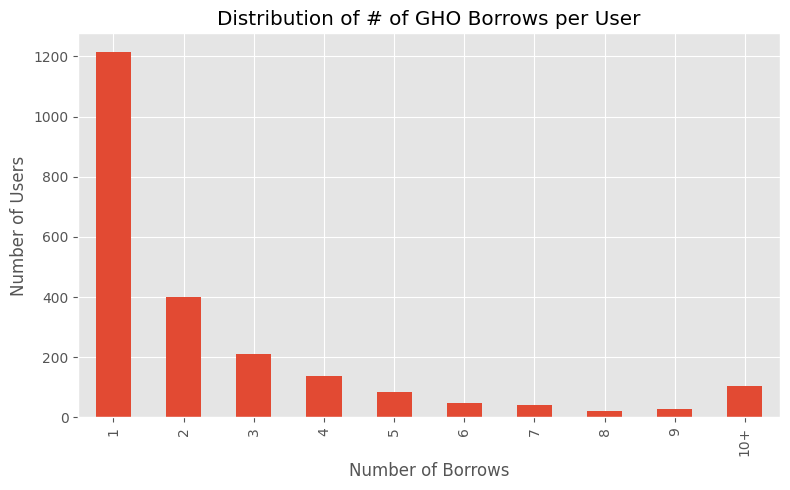

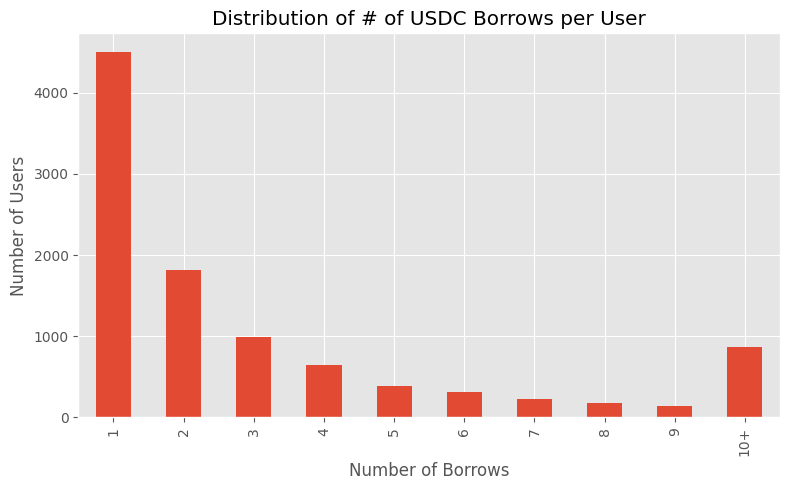

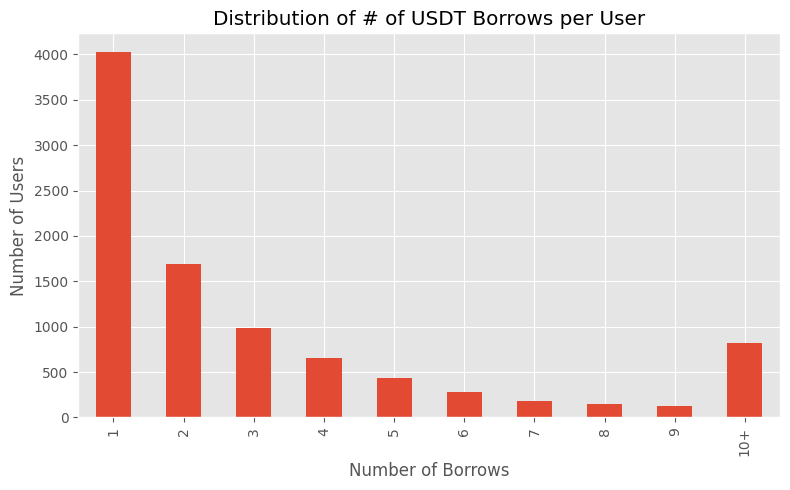

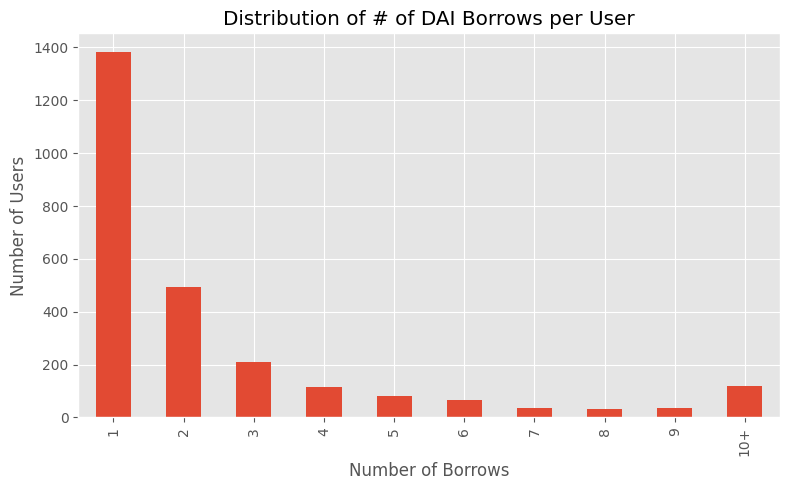

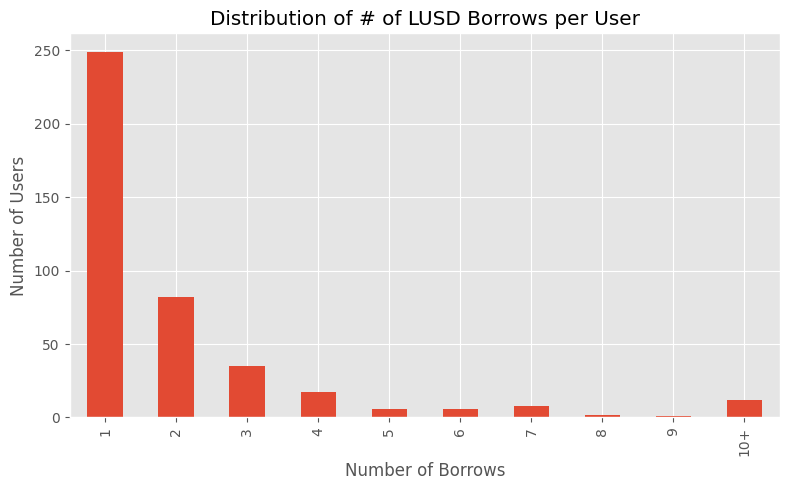

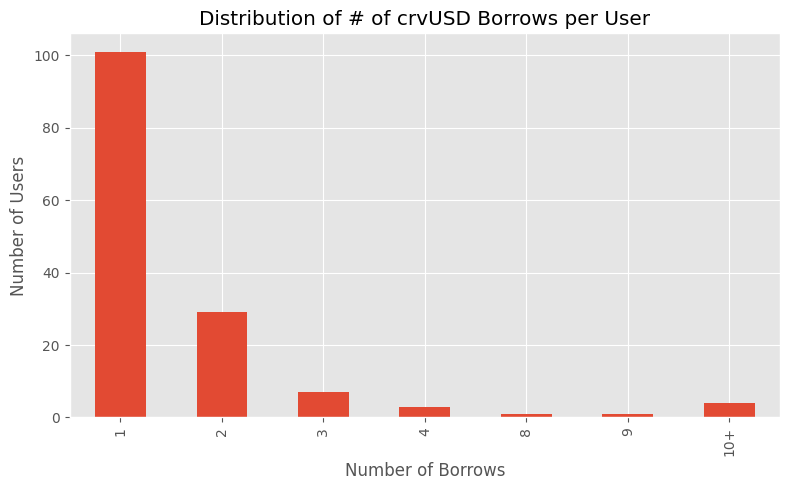

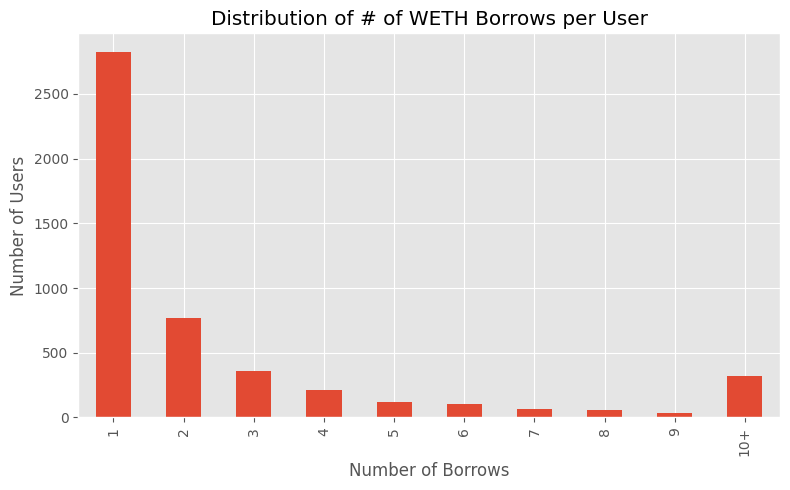

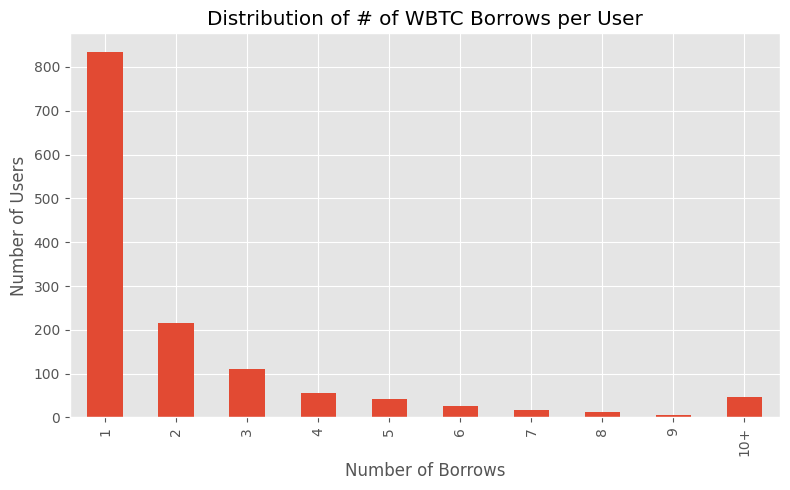

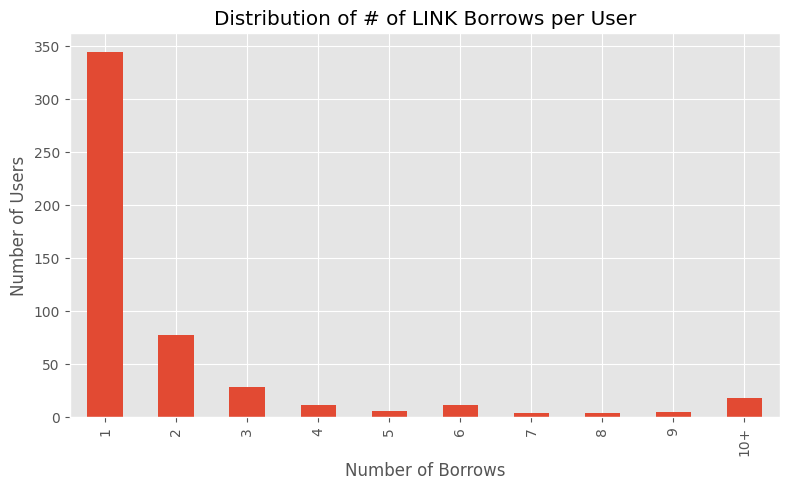

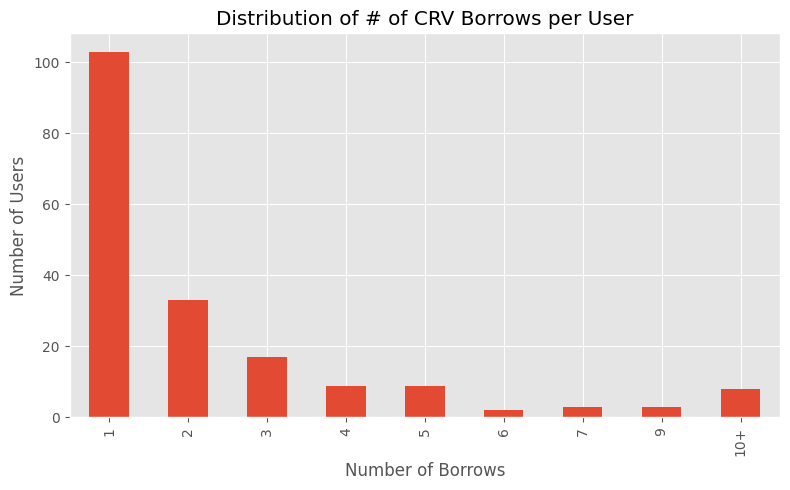

In [30]:
def get_borrow_count_per_token(token, history):
    return len([e for e in history if e['reserve']['symbol'] == token])

total_counts = {}
tokens_of_interest = ["GHO", "USDC", "USDT", "DAI", "LUSD", "crvUSD", "WETH", "WBTC", "LINK", "CRV"]
for token in tokens_of_interest:
    user_counts = {}
    for user in data:
        if user['borrowHistory']:
            num_borrows = get_borrow_count_per_token(token, user['borrowHistory'])
            if num_borrows == 0:
                continue
            user_counts[user['id']] = num_borrows
    df_txs = pd.DataFrame.from_dict(user_counts, orient='index').reset_index()
    df_txs.columns = ['user', 'count']
    df_txs['count'] = np.where(df_txs['count'] > 10, 10, df_txs['count'])
    counts = df_txs['count'].value_counts().sort_index()
    counts = counts.rename(index={10: '10+'})
    total_counts[token] = counts.to_dict()
    
    fig, ax = plt.subplots(figsize=(8, 5))
    counts.plot(kind='bar', ax=ax)
    
    ax.set_xlabel('Number of Borrows')
    ax.set_ylabel('Number of Users')
    ax.set_title(f'Distribution of # of {token} Borrows per User')
    
    plt.tight_layout()
    plt.show()

And in percentages

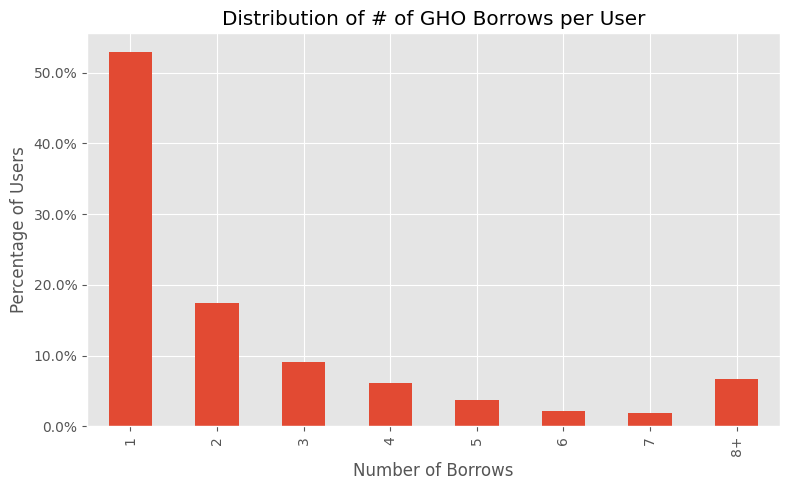

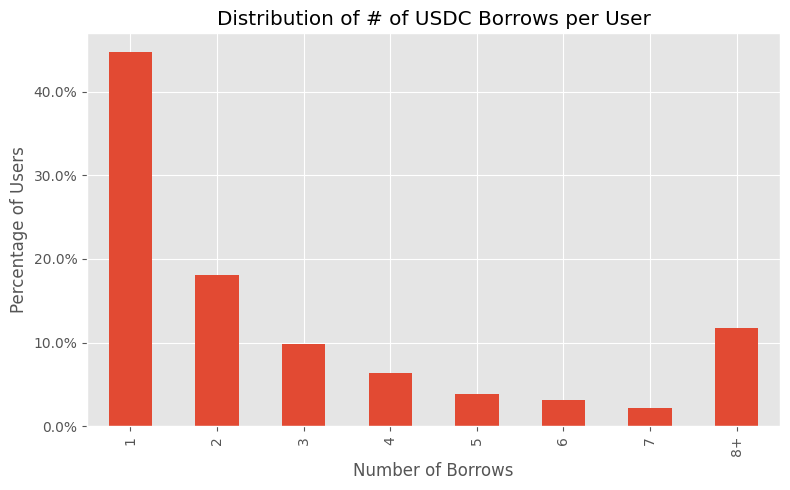

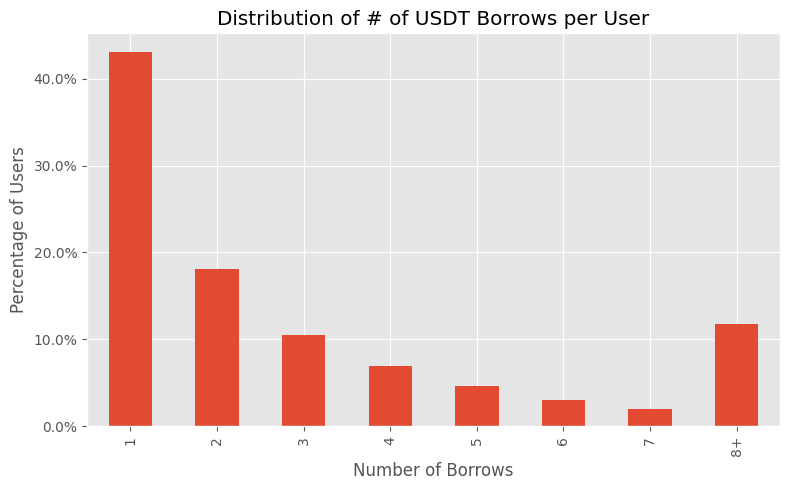

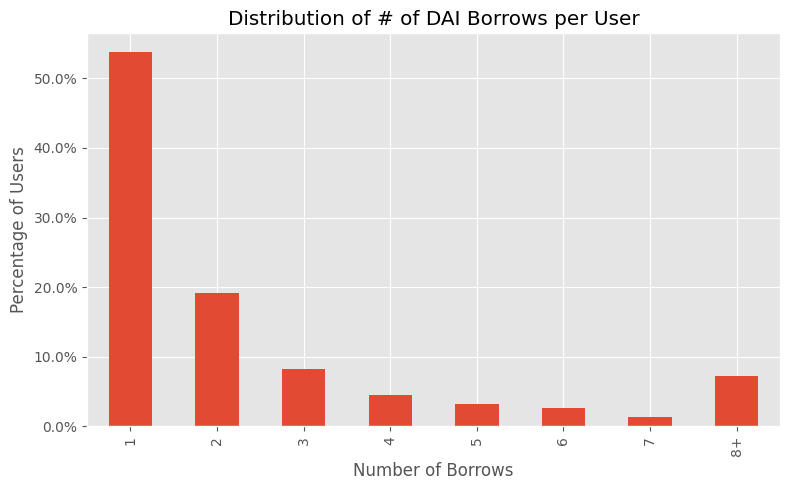

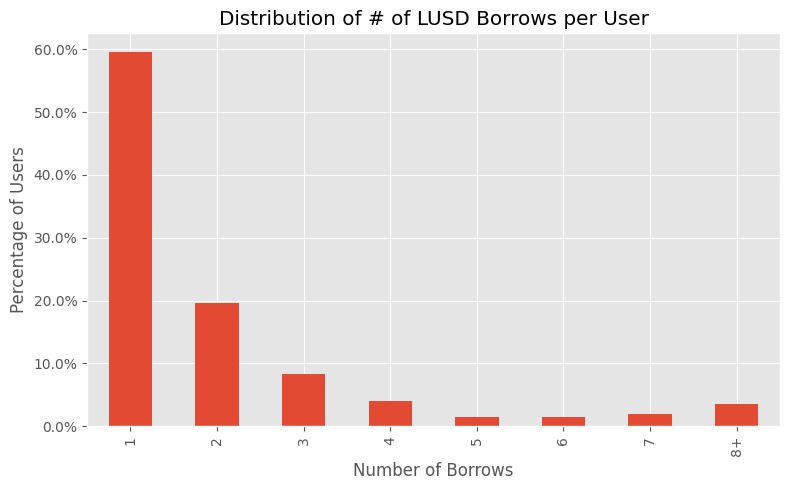

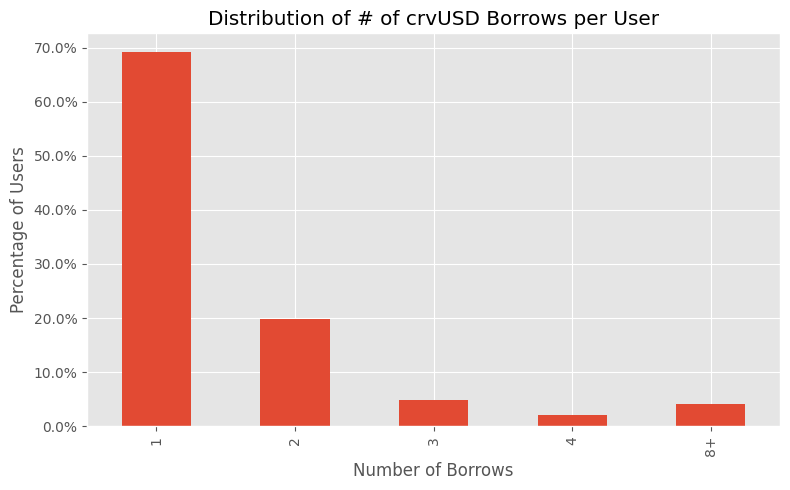

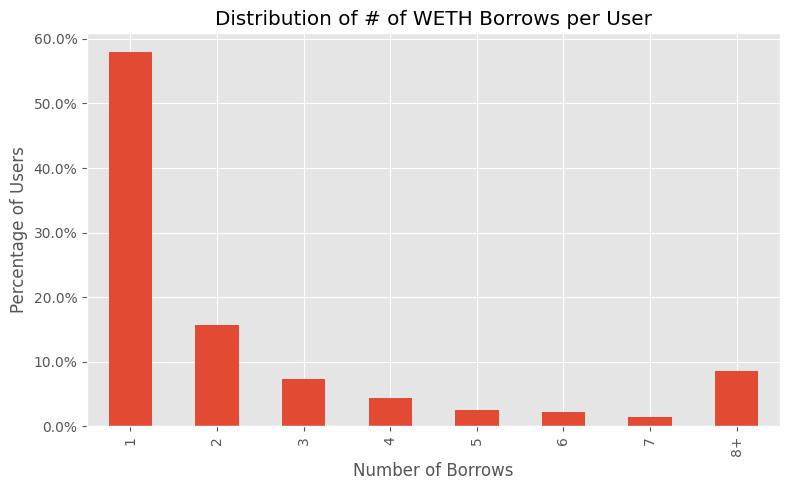

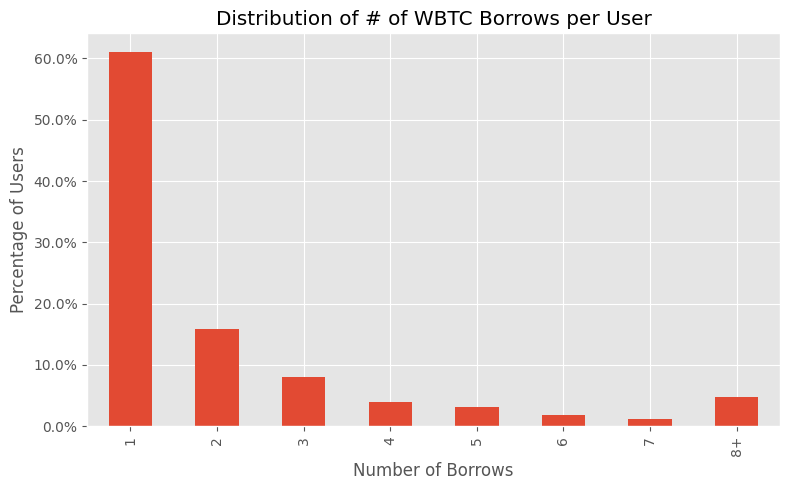

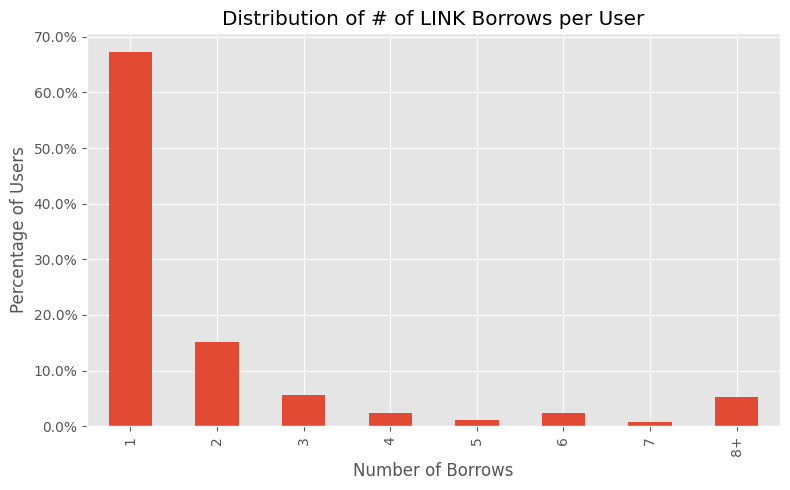

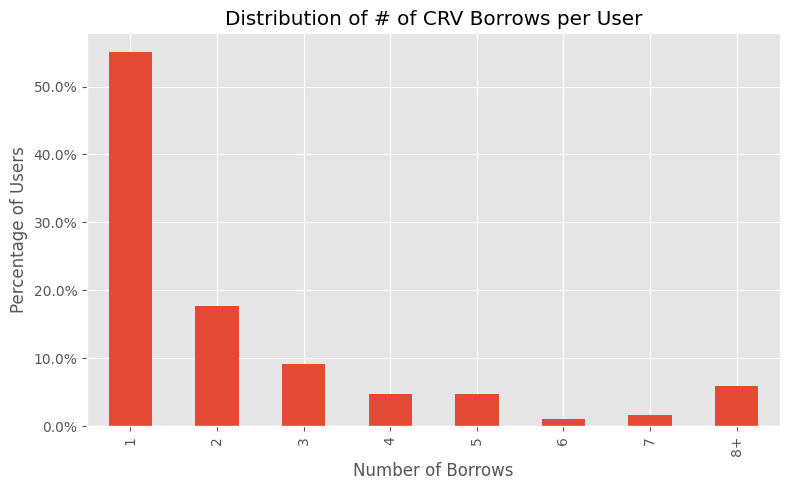

In [39]:

total_counts = {}
for token in tokens_of_interest:
    user_counts = {}
    for user in data:
        if user['borrowHistory']:
            count = get_borrow_count_per_token(token, user['borrowHistory'])
            if count > 0:
                user_counts[user['id']] = count
    
    df_txs = pd.DataFrame.from_dict(user_counts, orient='index').reset_index()
    df_txs.columns = ['user', 'count']
    df_txs['count'] = np.where(df_txs['count'] > 8, 8, df_txs['count'])
    
    counts = df_txs['count'].value_counts().sort_index()
    counts = counts.rename(index={8: '8+'})
    
    percentages = (counts / counts.sum()) * 100
    total_counts[token] = percentages.to_dict()
    
    fig, ax = plt.subplots(figsize=(8, 5))
    percentages.plot(kind='bar', ax=ax)
    
    ax.set_xlabel('Number of Borrows')
    ax.set_ylabel('Percentage of Users')
    ax.set_title(f'Distribution of # of {token} Borrows per User')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    
    plt.tight_layout()
    plt.show()

In [40]:
total_counts

{'GHO': {1: 52.938615585546366,
  2: 17.414018284719198,
  3: 9.14235959947758,
  4: 6.051371353939921,
  5: 3.744013931214628,
  6: 2.133217239878102,
  7: 1.872006965607314,
  '8+': 6.704397039616891},
 'USDC': {1: 44.72012703453751,
  2: 18.023025009924574,
  3: 9.884874950377135,
  4: 6.361651448987693,
  5: 3.900357284636761,
  6: 3.1560142913854707,
  7: 2.203255260023819,
  '8+': 11.750694720127035},
 'USDT': {1: 43.05703909421064,
  2: 18.105105746635335,
  3: 10.55330057679983,
  4: 6.975005340739158,
  5: 4.603717154454177,
  6: 3.001495406964324,
  7: 1.9653920102542193,
  '8+': 11.73894466994232},
 'DAI': {1: 53.78935095219588,
  2: 19.16051301982122,
  3: 8.200544111931597,
  4: 4.4306257287213375,
  5: 3.225806451612903,
  6: 2.6039642440730666,
  7: 1.3602798289933928,
  '8+': 7.228915662650602},
 'LUSD': {1: 59.569377990430624,
  2: 19.617224880382775,
  3: 8.373205741626794,
  4: 4.0669856459330145,
  5: 1.4354066985645932,
  6: 1.4354066985645932,
  7: 1.9138755980861

## Normalizing for Age

Because the above favors older assets like USDT/USDC, we will filter out any borrow that was taken before launch date of GHO

In [ ]:
def get_borrow_count_per_token(token, history):
    return len([e for e in history if (e['reserve']['symbol'] == token) and (e[''])])

total_counts = {}
tokens_of_interest = ["GHO", "USDC", "USDT", "DAI", "LUSD", "crvUSD", "WETH", "WBTC", "LINK", "CRV"]

for token in tokens_of_interest:
    user_counts = {}
    for user in data:
        if user['borrowHistory']:
            count = get_borrow_count_per_token(token, user['borrowHistory'])
            if count > 0:
                user_counts[user['id']] = count
    
    df_txs = pd.DataFrame.from_dict(user_counts, orient='index').reset_index()
    df_txs.columns = ['user', 'count']
    df_txs['count'] = np.where(df_txs['count'] > 10, 10, df_txs['count'])
    
    counts = df_txs['count'].value_counts().sort_index()
    counts = counts.rename(index={10: '10+'})
    
    percentages = (counts / counts.sum()) * 100
    total_counts[token] = percentages.to_dict()
    
    fig, ax = plt.subplots(figsize=(8, 5))
    percentages.plot(kind='bar', ax=ax)
    
    ax.set_xlabel('Number of Borrows')
    ax.set_ylabel('Percentage of Users')
    ax.set_title(f'Distribution of # of {token} Borrows per User')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    
    plt.tight_layout()
    plt.show()

## User categorization

We want to see the number of users who:
- have never used GHO
- have started by borrowing GHO and then borrowed other tokens
- have starts with other tokens but then borrowed GHO
- have only ever used GHO

In [12]:
user_type = {}
for history in histories:
    for entry in data:
        if not entry['borrowHistory']:
            continue
        user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
        user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
        if len(user_gho_transactions) == 0:
            user_type[entry['id']] = "Never borrowed GHO"
        elif len(user_gho_transactions) == len(user_ordered_tx):
            user_type[entry['id']] = "Only borrowed GHO"
        elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
            user_type[entry['id']] = "Started with GHO"
        else:
            user_type[entry['id']] = "Started with other token"


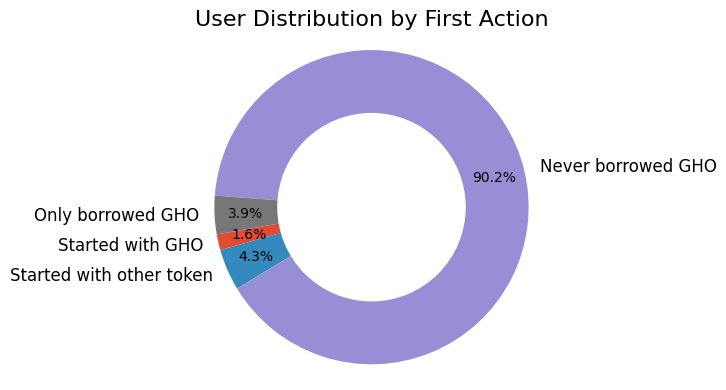

In [13]:
user_type_counts = {type: list(user_type.values()).count(type) for type in set(user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=190, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

GHO users are a small fraction of the total user base, but let's check the distribution of the categories when we limit ourselves to GHO users only

In [8]:
gho_user_type = {}
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
            if len(user_gho_transactions) == 0:
                gho_user_type[entry['id']] = "Never borrowed GHO"
            elif len(user_gho_transactions) == len(user_ordered_tx):
                gho_user_type[entry['id']] = "Only borrowed GHO"
            elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
                gho_user_type[entry['id']] = "Started with GHO"
            else:
                gho_user_type[entry['id']] = "Started with other token"


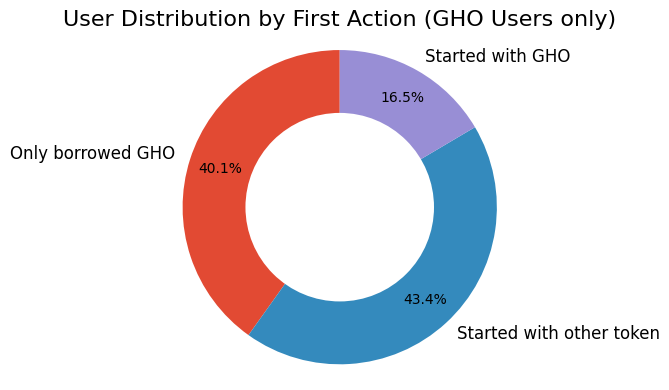

In [9]:
user_type_counts = {type: list(gho_user_type.values()).count(type) for type in set(gho_user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action (GHO Users only)", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

This would mean that the majority of GHO users are actually new AAVE users. Let's check if those users are indeed new or if they maybe had used AAVE V2 before.
To do so we pull data from the AAVE V2 subgraph using `pull_v2.py`

In [15]:
with open('results_v2.json', 'r') as fp:
    res = json.load(fp)
v2_data = []
for entry in res:
    v2_data += entry['data']['users']

In [18]:
v2_users = set([entry['id'] for entry in v2_data])
len(v2_users)

120593

In [17]:
v2_borrowers = set([entry['id'] for entry in v2_data if entry['borrowHistory']])
len(v2_borrowers)

54479

In [22]:
len(gho_users) / (len(v2_borrowers) + len(borrowers)) * 100

2.950924974306269

In [14]:
import pickle
with open('v2_users.pkl', 'wb') as fp:
    pickle.dump(v2_users, fp)

NameError: name 'v2_users' is not defined

In [66]:
print(f"GHO Users who had used Aave V2: {len(gho_users & v2_users)} or {len(gho_users & v2_users)/len(gho_users)*100}%")

GHO Users who had used Aave V2: 613 or 26.68698302133217%


In [19]:
print(f"GHO Users who had borrowed on Aave V2: {len(gho_users & v2_borrowers)} or {len(gho_users & v2_borrowers)/len(gho_users)*100}%")

GHO Users who had borrowed on Aave V2: 570 or 24.81497605572486%


Now let's see how many of those overlap with the users who started with other tokens

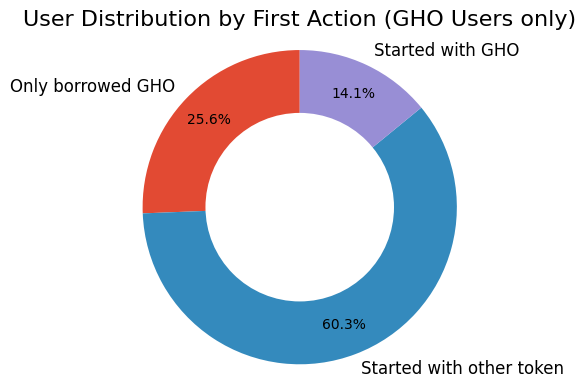

In [12]:
v2_user_type = {k: v for k, v in gho_user_type.items() if k in v2_users}
user_type_counts = {type: list(v2_user_type.values()).count(type) for type in set(v2_user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action (GHO Users only)", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

Ok, so a good chunk of the new users had actually already used V2 before. Let's redo the chart adding in previous v2 users as a category on its own

In [13]:
user_type = {}
for history in histories:
    for entry in data:
        user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
        user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
        if len(user_gho_transactions) == 0:
            user_type[entry['id']] = "Never borrowed GHO"
        elif entry['id'] in v2_users:
            user_type[entry['id']] = "Started with other token (V2)"            
        elif len(user_gho_transactions) == len(user_ordered_tx):
            user_type[entry['id']] = "Only borrowed GHO"
        elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
            user_type[entry['id']] = "Started with GHO"
        else:
            user_type[entry['id']] = "Started with other token (V3)"


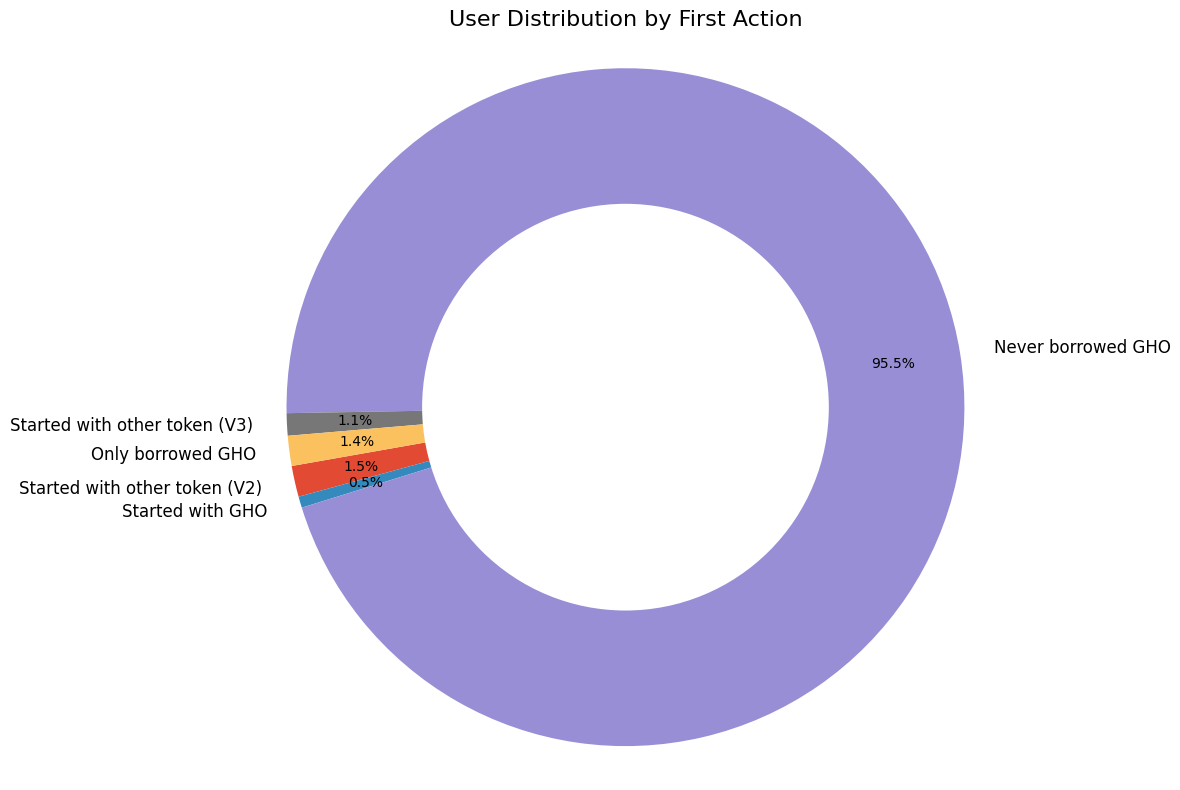

In [14]:
user_type_counts = {type: list(user_type.values()).count(type) for type in set(user_type.values())}
total_users = sum(user_type_counts.values())

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=190, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

{'Started with other token (V3)': 599, 'Only borrowed GHO': 823, 'Started with other token (V2)': 570, 'Started with GHO': 305}
2297


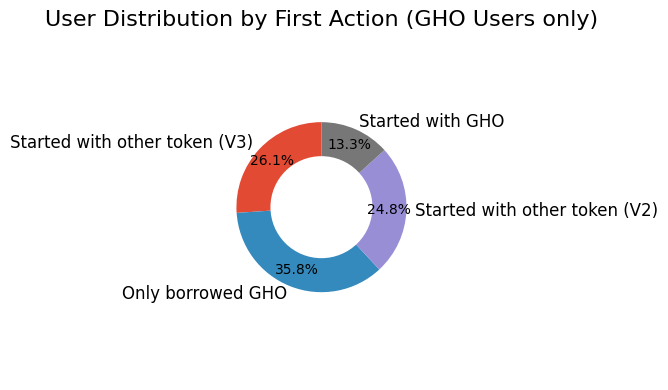

In [83]:
gho_user_type = {}
v2_dict = {v['id']: v for v in v2_data}
gho_only_borrows = []
gho_new_users = []

for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
            if len(user_gho_transactions) == 0:
                gho_user_type[entry['id']] = "Never borrowed GHO"
            elif (entry['id'] in v2_users) and len(v2_dict[entry['id']][history]) > 0:
                gho_user_type[entry['id']] = "Started with other token (V2)"       
            elif len(user_gho_transactions) == len(user_ordered_tx):
                gho_user_type[entry['id']] = "Only borrowed GHO"
                gho_only_borrows += (user_ordered_tx)
                gho_new_users.append(entry['id'])
            elif user_ordered_tx[0]['reserve']['symbol'] == 'GHO':
                gho_user_type[entry['id']] = "Started with GHO"
                gho_new_users.append(entry['id'])
            else:
                gho_user_type[entry['id']] = "Started with other token (V3)"
                
user_type_counts = {type: list(gho_user_type.values()).count(type) for type in set(gho_user_type.values())}
total_users = sum(user_type_counts.values())
print(user_type_counts)
print(total_users)

labels = list(user_type_counts.keys())
sizes = [count / total_users * 100 for count in user_type_counts.values()]

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("User Distribution by First Action (GHO Users only)", fontsize=16)

plt.setp(autotexts, size=10)
plt.setp(texts, size=12)

plt.tight_layout()
plt.show()

In [84]:
with open('gho_new_users.pkl', 'wb') as fp:
    pickle.dump(gho_new_users, fp)

In [76]:
len(set([_['caller']['id'] for _ in gho_only_borrows]) & set(v2_users))

94

How does the proportion of users who ONLY use GHO compare to other collaterals?

In [18]:
single_product_users = 0
for history in histories:
    for entry in data:
        borrowed_tokens = list(set([c['reserve']['symbol'] for c in entry[history]]))
        if len(borrowed_tokens) == 1:
            single_product_users += 1

In [23]:
single_product_users / len(data) * 100

31.688454441958154

In [25]:
single_product_users

16144

In [30]:
all_tokens = []
for history in histories:
    for entry in data:
        all_tokens += [c['reserve']['symbol'] for c in entry[history]]

In [31]:
pd.Series(all_tokens).value_counts()

USDC      44881
USDT      40866
WETH      17691
DAI        7656
GHO        6684
WBTC       3615
wstETH     2847
LINK       1178
           1067
RPL        1041
rETH        935
LUSD        922
PYUSD       842
weETH       839
USDe        655
CRV         488
cbETH       456
UNI         453
FRAX        401
crvUSD      339
MKR         310
BAL         281
SNX         198
ENS         192
LDO         184
1INCH       131
ETHx         38
osETH        30
STG          27
FXS          25
KNC          13
dtype: int64

In [82]:
v2_dict = {v['id']: v for v in v2_data}

token = "USDC"
for token in  ["USDC", "USDT", "WETH", "DAI", "wstETH", "WBTC", "GHO", "LUSD", "PYUSD", "CRV", "crvUSD"]:
    user_actions = {}
    for history in histories:
        for entry in data:
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
    
            user_token_transactions = [c['txHash'] for c in user_transactions if c['reserve']['symbol'] == token]

            if len(user_token_transactions) == 0:
                continue
            elif len(user_token_transactions) == len(user_ordered_tx):
                user_actions[entry['id']] = f"Only ever borrowed {token}"
            elif ((user_ordered_tx[0]['v2'] == True) and (user_ordered_tx[0]['reserve']['symbol'] != token)):
                user_actions[entry['id']] = "Started with other token (V2)"
            elif user_ordered_tx[0]['reserve']['symbol'] == token:
                user_actions[entry['id']] = f"Started with {token}"
            else:
                user_actions[entry['id']] = "Started with other token (V3)"
                
    user_type_counts = {type: list(user_actions.values()).count(type) for type in set(user_actions.values())}
    total_users = sum(user_type_counts.values())
    #print(user_type_counts)
    #print(total_users)
    
    labels = list(user_type_counts.keys())
    sizes = [count / total_users * 100 for count in user_type_counts.values()]
    print("***")
    print(token)
    print(labels)
    print(sizes)
    
    # fig, ax = plt.subplots(figsize=(6, 4))
    # wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8)
    
    # centre_circle = plt.Circle((0, 0), 0.60, fc='white')
    # fig.gca().add_artist(centre_circle)
    
    # ax.axis('equal')
    # plt.title(f"User Distribution by First Action ({token} Users only)", fontsize=16)
    
    # plt.setp(autotexts, size=10)
    # plt.setp(texts, size=12)
    
    # plt.tight_layout()
    # plt.show()

***
USDC
['Started with other token (V3)', 'Started with USDC', 'Only ever borrowed USDC', 'Started with other token (V2)']
[17.719829120683517, 24.48380206479174, 44.766820932716264, 13.029547881808472]
***
USDT
['Started with other token (V3)', 'Started with other token (V2)', 'Only ever borrowed USDT', 'Started with USDT']
[20.768319178352755, 15.712028441635395, 45.91151491210745, 17.608137467904406]
***
WETH
['Started with other token (V3)', 'Started with WETH', 'Started with other token (V2)', 'Only ever borrowed WETH']
[19.506216074242687, 21.274732971458587, 17.369987742952198, 41.849063211346525]
***
DAI
['Started with other token (V3)', 'Only ever borrowed DAI', 'Started with other token (V2)', 'Started with DAI']
[19.85494106980961, 25.173768510123907, 27.107887579329105, 27.863402840737383]
***
wstETH
['Started with other token (V3)', 'Started with wstETH', 'Started with other token (V2)', 'Only ever borrowed wstETH']
[34.462151394422314, 17.330677290836654, 15.039840637450

In [59]:
user_transactions

[]

For those who start with other tokens, let's see what they usually start with:

In [75]:
v2_dict = {v['id']: v for v in v2_data}

In [79]:
gho_pre_tokens = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            user_pre_tokens = []
            for ordered_tx in user_ordered_tx:
                if ordered_tx['reserve']['symbol'] == 'GHO':
                    break
                user_pre_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))
            gho_pre_tokens += list(set(user_pre_tokens))

<Axes: title={'center': 'Tokens borrowed prior to GHO'}>

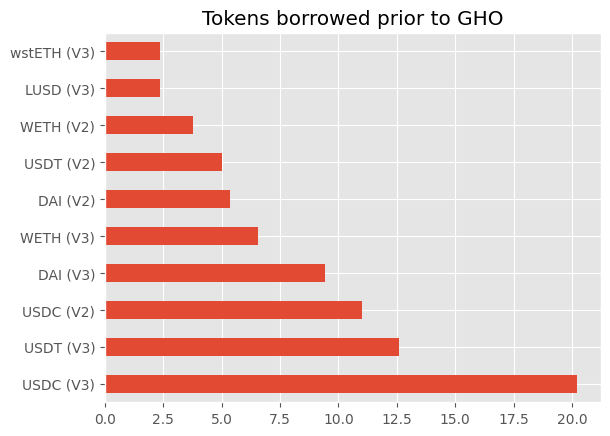

In [97]:
pre_series = pd.Series(gho_pre_tokens)
(pre_series.value_counts() / sum(pre_series.value_counts()) * 100)[:10].plot.barh(title="Tokens borrowed prior to GHO")

## Gateway Tokens

Let's only do the very first token they borrow.

*Note*: On blog do dropdown chart with select GHO/All users/Non GHO user

In [88]:
gho_first_tokens = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            ordered_tx = user_ordered_tx[0]
            gho_first_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))

<Axes: title={'center': 'First token borrowed by GHO users'}>

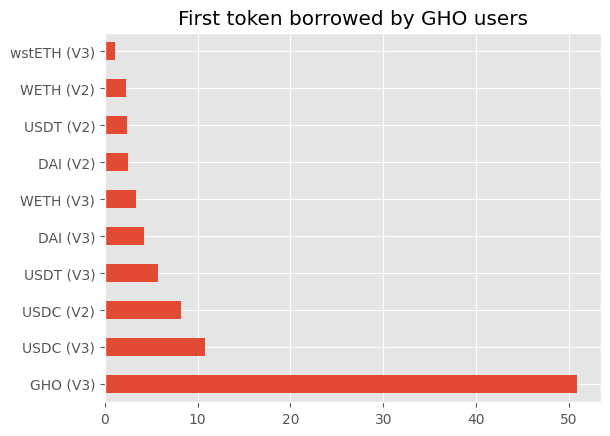

In [89]:
first_series = pd.Series(gho_first_tokens)
(first_series.value_counts() / sum(first_series.value_counts()) * 100)[:10].plot.barh(title="First token borrowed by GHO users")

Let's see if there are any difference compared to what all users start by borrowing

In [92]:
all_first_tokens = []
for history in histories:
    for entry in data:
        if len(entry[history]) > 0:
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            ordered_tx = user_ordered_tx[0]
            all_first_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))

<Axes: title={'center': 'First token borrowed by all users'}>

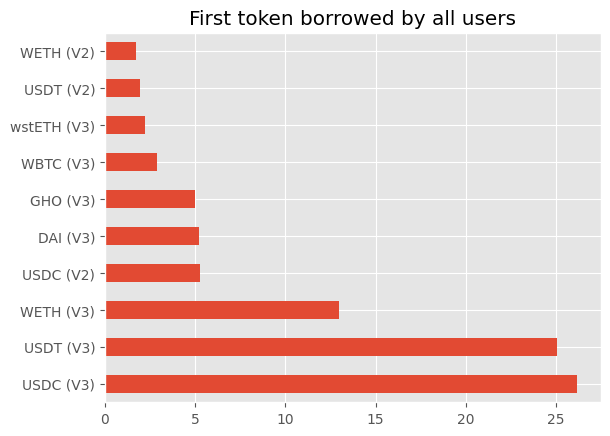

In [93]:
first_series = pd.Series(all_first_tokens)
(first_series.value_counts() / sum(first_series.value_counts()) * 100)[:10].plot.barh(title="First token borrowed by all users")

<Axes: title={'center': 'First token borrowed by all (non-GNO) users'}>

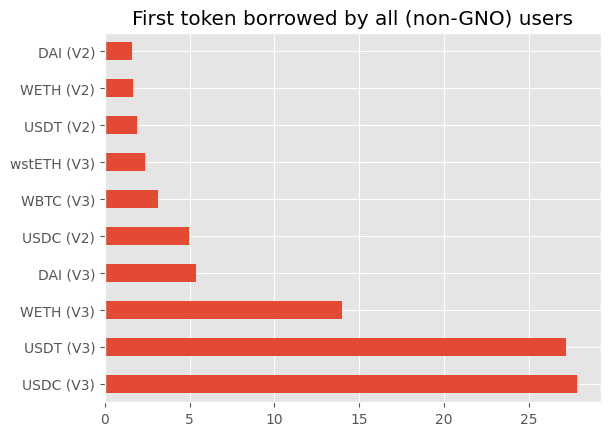

In [94]:
all_first_tokens = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            continue
        if len(entry[history]) > 0:
            user_transactions = [{'v2': False, **borrow} for borrow in entry[history]]
            if entry['id'] in v2_users:
                user_transactions += [{'v2': True, **borrow} for borrow in v2_dict[entry['id']][history]]
            
            user_ordered_tx = sorted(user_transactions, key=lambda x: x['timestamp'])
            ordered_tx = user_ordered_tx[0]
            all_first_tokens.append(ordered_tx['reserve']['symbol'] + (' (V2)' if ordered_tx['v2'] else ' (V3)'))

first_series = pd.Series(all_first_tokens)
(first_series.value_counts() / sum(first_series.value_counts()) * 100)[:10].plot.barh(title="First token borrowed by all (non-GNO) users")

Main difference is in the popularity of GNO, unsurprising as one third of GNO users only borrow GNO.
Another is the difference in the popularity of crypto. Only very few users borrow ETH and hardly any borrow BTC when that behavior is otherwise much more common with regular users.

# All token borrowed (indiscrimate)

## GHO users

In [17]:
def get_borrowed(history):
    return list(set([entry['reserve']['symbol'] for entry in history]))


gho_borrows = []
for user in data:
    if user['id'] in gho_users:
        gho_borrows += get_borrowed(user['borrowHistory'])

In [18]:
import pandas as pd
pd.Series(gho_borrows).value_counts() / sum(pd.Series(gho_borrows).value_counts()) * 100

GHO       40.561540
USDC      16.228148
USDT      12.149038
DAI        7.010419
WETH       6.992760
WBTC       2.595797
wstETH     2.383895
LUSD       2.313262
PYUSD      1.695215
FRAX       1.130143
LINK       0.971217
crvUSD     0.918241
rETH       0.794632
USDe       0.759315
cbETH      0.494438
RPL        0.423804
CRV        0.423804
UNI        0.353170
MKR        0.264877
SNX        0.229560
LDO        0.229560
           0.229560
1INCH      0.229560
BAL        0.211902
ENS        0.194243
KNC        0.035317
STG        0.035317
ETHx       0.035317
FXS        0.035317
weETH      0.035317
osETH      0.035317
dtype: float64

## v3 Users

In [3]:
def get_borrowed(history):
    return list(set([entry['reserve']['symbol'] for entry in history]))


non_gho_borrows = []
for user in data:
    if user['id'] not in gho_users:
        non_gho_borrows += get_borrowed(user['borrowHistory'])

In [15]:
pd.Series(non_gho_borrows).value_counts() / sum(pd.Series(non_gho_borrows).value_counts()) * 100

USDC      30.688026
USDT      29.069339
WETH      15.017259
DAI        7.292470
WBTC       4.091960
wstETH     2.912296
LINK       1.534904
LUSD       0.961828
rETH       0.911559
USDe       0.878046
RPL        0.804316
PYUSD      0.717182
UNI        0.663561
cbETH      0.586481
CRV        0.546265
           0.489293
FRAX       0.425617
BAL        0.325078
crvUSD     0.315024
MKR        0.315024
LDO        0.298267
ENS        0.234592
SNX        0.234592
1INCH      0.214484
weETH      0.211133
ETHx       0.093837
osETH      0.056972
STG        0.050270
FXS        0.036865
KNC        0.023459
dtype: float64

# Correlations

In [4]:
total_borrows = []
for user in data:
    total_borrows.append(get_borrowed(user['borrowHistory']))

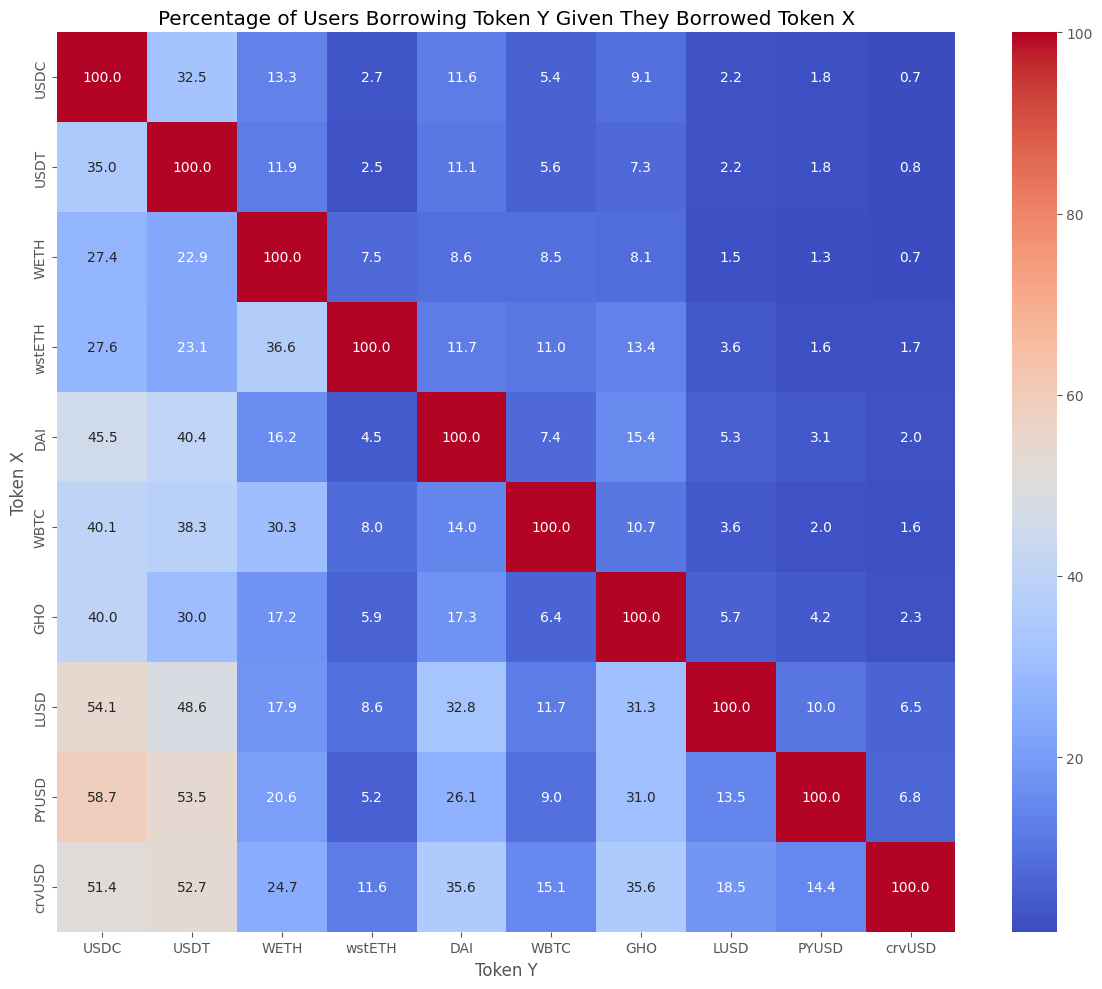

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tokens_of_interest = ["USDC", "USDT", "WETH", "wstETH", "DAI", "WBTC", "GHO", "LUSD", "PYUSD", "crvUSD"]

def create_token_matrix(total_borrows):
    token_matrix = np.zeros((len(tokens_of_interest), len(tokens_of_interest)))
    
    for user_borrows in total_borrows:
        user_tokens = set(user_borrows) & set(tokens_of_interest)
        for i, token1 in enumerate(tokens_of_interest):
            if token1 in user_tokens:
                for j, token2 in enumerate(tokens_of_interest):
                    if token2 in user_tokens:
                        token_matrix[i, j] += 1
    
    return token_matrix

def calculate_percentages(token_matrix):
    percentage_matrix = token_matrix / np.diag(token_matrix)[:, np.newaxis] * 100
    return percentage_matrix

def plot_heatmap(percentage_matrix):
    plt.figure(figsize=(12, 10))
    sns.heatmap(percentage_matrix, annot=True, fmt='.1f', cmap='coolwarm', xticklabels=tokens_of_interest, yticklabels=tokens_of_interest)
    plt.title('Percentage of Users Borrowing Token Y Given They Borrowed Token X')
    plt.xlabel('Token Y')
    plt.ylabel('Token X')
    plt.tight_layout()
    plt.show()

token_matrix = create_token_matrix(total_borrows)
percentage_matrix = calculate_percentages(token_matrix)
df_percentages = pd.DataFrame(percentage_matrix, index=tokens_of_interest, columns=tokens_of_interest)

plot_heatmap(df_percentages)

In [ ]:
df_percen

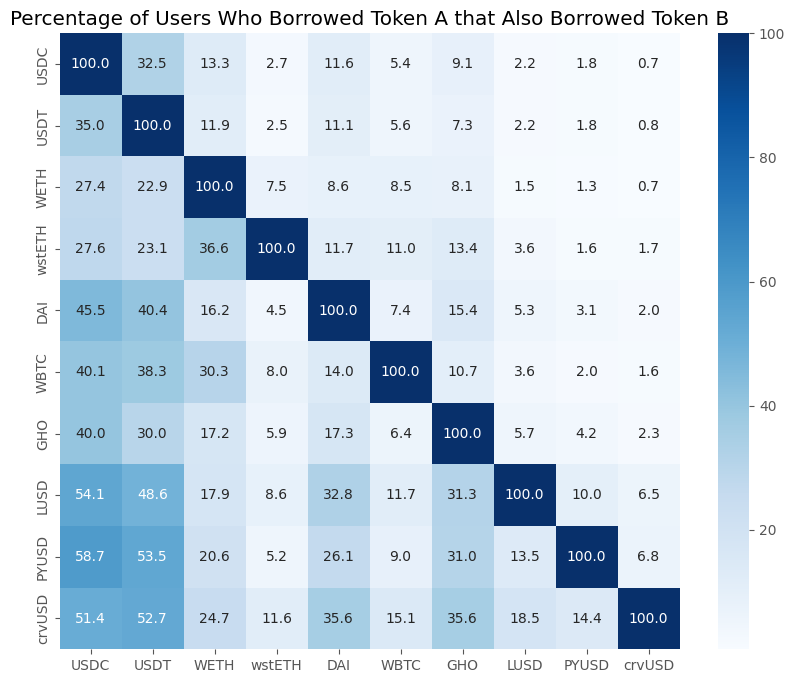

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tokens_of_interest = ["USDC", "USDT", "WETH", "wstETH", "DAI", "WBTC", "GHO", "LUSD", "PYUSD", "crvUSD"]
token_borrowers = {token: set() for token in tokens_of_interest}
for idx, borrowed_tokens in enumerate(total_borrows):
    borrowed_set = set(borrowed_tokens)
    for token in tokens_of_interest:
        if token in borrowed_set:
            token_borrowers[token].add(idx)
data_matrix = pd.DataFrame(index=tokens_of_interest, columns=tokens_of_interest)
for token_a in tokens_of_interest:
    users_a = token_borrowers[token_a]
    total_users_a = len(users_a)
    for token_b in tokens_of_interest:
        users_b = token_borrowers[token_b]
        users_a_and_b = users_a & users_b
        percentage = (len(users_a_and_b) / total_users_a) * 100 if total_users_a > 0 else 0
        data_matrix.loc[token_a, token_b] = percentage
data_matrix = data_matrix.astype(float)
plt.figure(figsize=(10,8))
sns.heatmap(data_matrix, annot=True, fmt=".1f", cmap="Blues")
plt.title("Percentage of Users Who Borrowed Token A that Also Borrowed Token B")
plt.show()


In [36]:
a = [k for k in data if any([_ for _ in k['borrowHistory'] if _['reserve']['symbol'] == 'USDT'])]

In [37]:
len(a)

9362

In [45]:
data_matrix.astype(float).to_dict()

{'USDC': {'USDC': 100.0,
  'USDT': 35.00320444349498,
  'WETH': 27.414394094730365,
  'wstETH': 27.589641434262944,
  'DAI': 45.5110765643218,
  'WBTC': 40.131578947368425,
  'GHO': 40.008707009142356,
  'LUSD': 54.066985645933016,
  'PYUSD': 58.70967741935483,
  'crvUSD': 51.369863013698634},
 'USDT': {'USDC': 32.52282651845971,
  'USDT': 100.0,
  'WETH': 22.862415419315152,
  'wstETH': 23.107569721115535,
  'DAI': 40.38087835211815,
  'WBTC': 38.30409356725146,
  'GHO': 29.952111449717023,
  'LUSD': 48.5645933014354,
  'PYUSD': 53.5483870967742,
  'crvUSD': 52.73972602739726},
 'WETH': {'USDC': 13.269154426359666,
  'USDT': 11.909848323007905,
  'WETH': 100.0,
  'wstETH': 36.55378486055777,
  'DAI': 16.245627671978234,
  'WBTC': 30.336257309941523,
  'GHO': 17.23987810187201,
  'LUSD': 17.942583732057415,
  'PYUSD': 20.64516129032258,
  'crvUSD': 24.65753424657534},
 'wstETH': {'USDC': 2.749106788408098,
  'USDT': 2.478102969450972,
  'WETH': 7.525117900348575,
  'wstETH': 100.0,
  '